2
3
Mechanical Energy = 
(4.9050000000000002 * (1 - c(0)) + 0.125 * pow(thetadot(0), 2))
V =
2.4401173920689034*1 + 0.12628048056006891*thetadot(0)^2 + -4.8801918960375099*c(0) + 2.4400745039686065*c(0)^2 + -1.5617803522036323e-06*s(0) + 0.070015479867884006*s(0) * thetadot(0) + 4.0192337866877754e-06*s(0) * c(0) + 2.464884169711449*s(0)^2


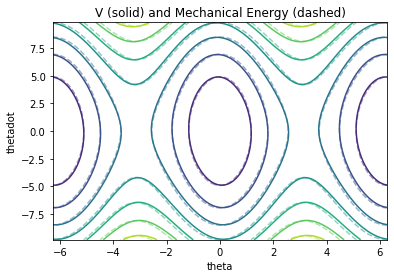

In [4]:
import sys
sys.path.append(
    "/Users/shenshen/drake-build/install/lib/python3.7/site-packages")
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import MathematicalProgram, Solve, Variables
from pydrake.symbolic import Polynomial
from pydrake.examples.pendulum import PendulumParams

prog = MathematicalProgram()

# Declare the "indeterminates", x.  These are the variables which define the
# polynomials, but are NOT decision variables in the optimization.  We will
# add constraints below that must hold FOR ALL x.
s = prog.NewIndeterminates(1, 's')[0]
c = prog.NewIndeterminates(1, 'c')[0]
thetadot = prog.NewIndeterminates(1, 'thetadot')[0]
# TODO(russt): bind the sugar methods so I can write
#  x = prog.NewIndeterminates(['s','c','thetadot'])
x = np.array([s, c, thetadot])

# Write out the dynamics in terms of sin(theta), cos(theta), and thetadot
p = PendulumParams()
f = [c*thetadot, -s*thetadot,
     (-p.damping()*thetadot - p.mass()*p.gravity()*p.length()*s) /
     (p.mass()*p.length()*p.length())]

# The fixed-point in this coordinate (because cos(0)=1).
x0 = np.array([0, 1, 0])

# Construct a polynomial V that contains all monomials with s,c,thetadot up
# to degree 2.
deg_V = 2
V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()

# Add a constraint to enforce that V is strictly positive away from x0.
# (Note that because our coordinate system is sine and cosine, V is also zero
# at theta=2pi, etc).
eps = 1e-4
constraint1 = prog.AddSosConstraint(V - eps*(x-x0).dot(x-x0))

# Construct the polynomial which is the time derivative of V.
Vdot = V.Jacobian(x).dot(f)
print(Polynomial(V,x).TotalDegree())
print(Polynomial(Vdot,x).TotalDegree())
print([Polynomial(i,x).TotalDegree() for i in f])
# Construct a polynomial L representing the "Lagrange multiplier".
deg_L = 2
L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()

# Add a constraint that Vdot is strictly negative away from x0 (but make an
# exception for the upright fixed point by multipling by s^2).
constraint2 = prog.AddSosConstraint(-Vdot - L*(s**2+c**2-1) -
                                    eps*(x-x0).dot(x-x0)*s**2)

# Add V(0) = 0 constraint
constraint3 = prog.AddLinearConstraint(
    V.Substitute({s: 0, c: 1, thetadot: 0}) == 0)

# Add V(theta=pi) = mgl, just to set the scale.
constraint4 = prog.AddLinearConstraint(
    V.Substitute({s: 1, c: 0, thetadot: 0}) == p.mass()*p.gravity()*p.length())

# Call the solver.
result = Solve(prog)
assert(result.is_success())

# Note that I've added mgl to the potential energy (relative to the textbook),
# so that it would be non-negative... like the Lyapunov function.
mgl = p.mass()*p.gravity()*p.length()
print('Mechanical Energy = ')
print(.5*p.mass()*p.length()**2*thetadot**2 + mgl*(1-c))

print('V =')
Vsol = Polynomial(result.GetSolution(V))
print(Vsol.RemoveTermsWithSmallCoefficients(1e-6))


# Plot the results as contour plots.
nq = 151
nqd = 151
q = np.linspace(-2*np.pi, 2*np.pi, nq)
qd = np.linspace(-2*mgl, 2*mgl, nqd)
Q, QD = np.meshgrid(q, qd)
Energy = .5*p.mass()*p.length()**2*QD**2 + mgl*(1-np.cos(Q))
Vplot = Q.copy()
env = {s: 0., c: 1., thetadot: 0}
for i in range(nq):
    for j in range(nqd):
        env[s] = np.sin(Q[i, j])
        env[c] = np.cos(Q[i, j])
        env[thetadot] = QD[i, j]
        Vplot[i, j] = Vsol.Evaluate(env)

# plt.rc('text', usetex=True)
fig, ax = plt.subplots()
ax.contour(Q, QD, Vplot)
ax.contour(Q, QD, Energy, alpha=0.5, linestyles='dashed')
ax.set_xlabel('theta')
ax.set_ylabel('thetadot')
ax.set_title('V (solid) and Mechanical Energy (dashed)')
plt.show()